In [1]:
import torch.nn as nn
import torch
import pandas as pd

In [2]:
class NeuralNetwork(nn.Module):
    """
    Neural Network Class for implementing neural networks for different loss and optimization functions.
    
    Attributes:
        input_size: An integer indicating number of input features.
        output_size: An integer indicating size of output.
        hidden_layer_size: An integer indicating size of hidden layer.
        
        w1: A vector (input_size X hidden_layers_sizes[0]) of floats required for training the neural network.
        wn: A vector (hidden_layers_sizes[-1] X output_size) for weights of final layer.
        
        activations: An array of strings indicating the activation functions for every layer.
        loss: A string indicating the loss function for the neural network.
        optimizer: A string indicating the optimization algorithm to be used to train the network.
    """
    def __init__(self, input_size, output_size, hidden_layer_size, activations, loss, optimizer):
        """
        Initializes Neural Network class attributes.
        
        Args:
            input_size (int): Number of features of the input.
            output_size (int): Dimension of output.
            hidden_layer_size (int): Number of neurons in the input layer.
            activations (list): List of strings giving the activations for each layer.
            loss (str): Loss function for the model.
            optimizer (str): Optimization algorithm for the model.
        """
        super(NeuralNetwork, self)
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_layer_size = hidden_layer_size
        
        self.w1 = torch.randn(self.input_size, self.hidden_layer_size, dtype=torch.double)
        self.wn = torch.randn(self.hidden_layer_size, self.output_size, dtype=torch.double)
    
        self.activations = activations
        self.loss = loss
        self.optimizer = optimizer
    
    
    def forward(self, X, w1=None, wn=None):
        """
        Forward pass of the neural network.
        
        Args:
            X (tensor): Input for the model. 
            w1 (tensor): Weights to be used for the first layer. (Optional Argument)
            wn (tensor): Weights to be used for the final layer. (Optional Argument)
            
        Returns:
            z (list): List of outputs from linear function at each layer.
            a (list): List of activation outputs from each layer.
        """
        if w1 is None:
            w1 = self.w1
        if wn is None:
            wn = self.wn
        z = []
        a = []
        z.append(torch.matmul(X, w1))
        a.append(self.evaluateActivation(self.activations[0])(z[-1]))
        z.append(torch.matmul(a[-1], wn))
        a.append(self.evaluateActivation(self.activations[1])(z[-1]))
        return z, a
    
    
    def backward(self, X, y, z, a, wn=None):
        """
        Backward Pass of the model.
        
        Args:
            X (Tensor): Input Data
            y (Tensor): Output Data
            z (list): List of outputs from linear layers.
            a (list): List of actiation outputs.
            wn (Tensor): Weights from final layer. (Optional Argument)
        """
        if wn is None:
            wn = self.wn
        dW = []
        dL_da_n = self.evaluateLossDerivative()(a[-1], y)
        da_n_dz_n = self.evaluateActivationDerivative(self.activations[1])(z[-1])
        dz_n_dWn = a[0]
        dL_dWn = torch.matmul(dz_n_dWn.T, (dL_da_n * da_n_dz_n))
        
        dz_n_da_1 = wn
        da_1_dz_1 = self.evaluateActivationDerivative(self.activations[0])(z[0])
        dz_1_dW1 = X
        dL_dW1 = torch.matmul(dz_1_dW1.T, (torch.matmul(dL_da_n * da_n_dz_n, dz_n_da_1.T)*da_1_dz_1))
        dW.append(dL_dW1)
        dW.append(dL_dWn)
        return dW
    
    
    def train(self, X, y, batch_size=100, iterations=500, alpha=1e-05, momentum_param=0, nesterov=False, decay_rate=0.999, beta1=0.9, beta2=0.999):
        """
        Function to train the neural network.
        """
        funVals = []
        ypred = None
        if self.optimizer == 'SGD':
            if momentum_param != 0:
                if nesterov:
                    funVals ,ypred = self.SGD(X, y, batch_size, iterations, alpha, momentum_param, True)
                else:
                    funVals, ypred = self.SGD(X, y, batch_size, iterations, alpha, momentum_param)
            else:
                funVals, ypred = self.SGD(X, y, batch_size, iterations, alpha)
        elif self.optimizer == 'Adagrad':
            funVals, ypred = self.Adagrad(X, y, batch_size, iterations, alpha)
        elif self.optimizer == 'RMSProp':
            funVals, ypred = self.RMSProp(X, y, batch_size, iterations, alpha, decay_rate)
        elif self.optimizer == 'Adam':
            funVals, ypred = self.Adam(X, y, batch_size, iterations, alpha, beta1, beta2)
        return funVals, ypred
    
    
    def SGD(self, X, y, batch_size=100, iterations=500, alpha=1e-05, momentum_param=0, nesterov=False):
        """
        Gradient Descent Algorithm
        """
        m, n = X.shape
        funVals = []
        ypred = []
        v1 = torch.zeros(self.w1.shape, dtype=torch.double)
        vn = torch.zeros(self.wn.shape, dtype=torch.double)
        n_iter = 0
        flag = True
        while flag:
            for i in range(m//batch_size):
                n_iter += 1
                if nesterov:
                    z, a = self.forward(X[i:i+batch_size], self.w1+momentum_param*v1, self.wn+momentum_param*vn)
                    dW = self.backward(X[i:i+batch_size], y[i:i+batch_size], z, a, self.wn+momentum_param*vn)
                else:
                    z, a = self.forward(X[i:i+batch_size])
                    dW = self.backward(X[i:i+batch_size], y[i:i+batch_size], z, a)
                v1 = momentum_param * v1 - alpha * dW[0]
                vn = momentum_param * vn - alpha * dW[1]
                self.w1 = self.w1 + v1
                self.wn = self.wn + vn
                if n_iter>iterations:
                    flag = False
                    break
                if n_iter%batch_size == 0:
                    ypred = self.predict(X)
                    funVals.append((self.evaluateLoss()(ypred, y)).item())
                    print(n_iter, funVals[-1])
            W = torch.cat([self.w1.flatten().reshape(-1, 1), self.wn.reshape(-1,1)])
            optCond = torch.matmul(W.T, W)
            if optCond < 1e-2 or n_iter>iterations:
                break
            ypred = self.predict(X)
            funVals.append((self.evaluateLoss()(ypred, y)).item())
            print(n_iter, funVals[-1])
        ypred = self.predict(X)
        if self.loss == 'CELoss':
            ypred = self.softmax(ypred)
        return funVals, ypred
    
    
    def Adagrad(self, X, y, batch_size=100, iterations=500, alpha=1e-5):
        """
        AdaGrad Optimizer
        """
        m, n = X.shape
        funVals = []
        ypred = []
        n_iter = 0
        flag = True
        smoothing_param = 1e-8
        cache1 = torch.zeros(self.w1.shape, dtype=torch.double)
        cache2 = torch.zeros(self.wn.shape, dtype=torch.double)
        while flag:
            for i in range(m//batch_size):
                n_iter += 1
                z, a = self.forward(X[i:i+batch_size])
                dW = self.backward(X[i:i+batch_size], y[i:i+batch_size], z, a)
                cache1 += dW[0]**2
                cache2 += dW[1]**2
                self.w1 += -(alpha/(torch.sqrt(cache1)+smoothing_param)) * dW[0]
                self.wn += -(alpha/(torch.sqrt(cache2)+smoothing_param)) * dW[1]
                if n_iter>iterations:
                    flag = False
                    break
                if n_iter%batch_size == 0:
                    ypred = self.predict(X)
                    funVals.append((self.evaluateLoss()(ypred, y)).item())
                    print(n_iter, funVals[-1])
            W = torch.cat([self.w1.flatten().reshape(-1, 1), self.wn.reshape(-1,1)])
            optCond = torch.matmul(W.T, W)
            if optCond < 1e-2 or n_iter>iterations:
                break
            ypred = self.predict(X)
            funVals.append((self.evaluateLoss()(ypred, y)).item())
            print(n_iter, funVals[-1])
        ypred = self.predict(X)
        if self.loss == 'CELoss':
            ypred = self.softmax(ypred)
        return funVals, ypred
    
    
    def RMSProp(self, X, y, batch_size=100, iterations=500, alpha=1e-04, decay_rate=0.999):
        """
        RMSProp Optimizer.
        """
        m, n = X.shape
        funVals = []
        ypred = []
        n_iter = 0
        flag = True
        smoothing_param = 1e-8
        cache1 = torch.zeros(self.w1.shape, dtype=torch.double)
        cache2 = torch.zeros(self.wn.shape, dtype=torch.double)
        while flag:
            for i in range(m//batch_size):
                n_iter += 1
                z, a = self.forward(X[i:i+batch_size])
                dW = self.backward(X[i:i+batch_size], y[i:i+batch_size], z, a)
                cache1 = decay_rate*cache1 + (1 - decay_rate) * dW[0]**2
                cache2 += dW[1]**2
                self.w1 += -(alpha/(torch.sqrt(cache1+smoothing_param))) * dW[0]
                self.wn += -(alpha/(torch.sqrt(cache2+smoothing_param))) * dW[1]
                if n_iter>iterations:
                    flag = False
                    break
                if n_iter%batch_size == 0:
                    ypred = self.predict(X)
                    funVals.append((self.evaluateLoss()(ypred, y)).item())
                    print(n_iter, funVals[-1])
            W = torch.cat([self.w1.flatten().reshape(-1, 1), self.wn.reshape(-1,1)])
            optCond = torch.matmul(W.T, W)
            if optCond < 1e-2 or n_iter>iterations:
                break
            ypred = self.predict(X)
            funVals.append((self.evaluateLoss()(ypred, y)).item())
            print(n_iter, funVals[-1])
        ypred = self.predict(X)
        if self.loss == 'CELoss':
            ypred = self.softmax(ypred)
        return funVals, ypred
    
    
    def Adam(self, X, y, batch_size=100, iterations=500, alpha=1e-04, beta1=0.9, beta2=0.999):
        """
        Adam Optimizer
        """
        m, n = X.shape
        funVals = []
        ypred = []
        n_iter = 0
        flag = True
        smoothing_param = 1e-8
        m1 = torch.zeros(self.w1.shape, dtype=torch.double)
        m2 = torch.zeros(self.wn.shape, dtype=torch.double)
        v1 = torch.zeros(self.w1.shape, dtype=torch.double)
        v2 = torch.zeros(self.wn.shape, dtype=torch.double)
        while flag:
            for i in range(m//batch_size):
                n_iter += 1
                z, a = self.forward(X[i:i+batch_size])
                dW = self.backward(X[i:i+batch_size], y[i:i+batch_size], z, a)
                m1 = beta1 * m1 + (1-beta1) * dW[0]
                v1 = beta2 * v1 + (1-beta2) * dW[0]**2
                m2 = beta1 * m2 + (1-beta1) * dW[1]
                v2 = beta2 * v2 + (1-beta2) * dW[1]**2
                self.w1 += -alpha*(m1/(1-beta1**n_iter))/(torch.sqrt((v1)/(1-beta2**n_iter)) + smoothing_param)
                self.wn += -alpha*(m2/(1-beta1**n_iter))/(torch.sqrt((v2)/(1-beta2**n_iter)) + smoothing_param)
                if n_iter>iterations:
                    flag = False
                    break
                if n_iter%batch_size == 0:
                    ypred = self.predict(X)
                    funVals.append((self.evaluateLoss()(ypred, y)).item())
                    print(n_iter, funVals[-1])
            W = torch.cat([self.w1.flatten().reshape(-1, 1), self.wn.reshape(-1,1)])
            optCond = torch.matmul(W.T, W)
            if optCond < 1e-2 or n_iter>iterations:
                break
            ypred = self.predict(X)
            funVals.append((self.evaluateLoss()(ypred, y)).item())
            print(n_iter, funVals[-1])
        ypred = self.predict(X)
        if self.loss == 'CELoss':
            ypred = self.softmax(ypred)
        return funVals, ypred
    
    
    def predict(self, X):
        """
        Predict function
        """
        _, a = self.forward(X)
        return a[-1]
    
    
    def reset_weights(self):
        """
        Reset Weights
        """
        self.w1 = torch.randn(self.input_size, self.hidden_layer_size, dtype=torch.double)
        self.wn = torch.randn(self.hidden_layer_size, self.output_size, dtype=torch.double)
    
    
    def evaluateActivation(self, activation):
        """
        Activation function
        """
        if activation == 'sigmoid' :
            def sigmoid(z):
                s = torch.exp(z)
                return s/(1+s)
            return sigmoid
#             return lambda z : torch.exp(z)/(1 + torch.exp(z))
        elif activation == 'relu':
            def relu(z):
                z1 = torch.clone(z)
                return z1.clamp(min=0)
            return relu
        elif activation == 'tanh':
            return lambda z : (2/(1+torch.exp(-2*z))) - 1
        return lambda z : z
    
    
    def evaluateActivationDerivative(self, activation):
        """
        Derivative of Activation Function
        """
        if activation == 'sigmoid':
            sigmoid = lambda z : torch.exp(z)/(1 + torch.exp(z))
            return lambda z : sigmoid(z) * (1 - sigmoid(z))
        elif activation == 'relu':
            def relu_derivative(z):
                z1 = torch.clone(z)
                z1[z>=0] = 1
                z1[z<0] = 0
                return z1
            return relu_derivative
        elif activation == 'tanh':
            tanh = lambda z : (2/(1+torch.exp(-2*z))) - 1
            return lambda z : 1 - tanh(z)**2
        return lambda z : 1
    
    
    def evaluateLoss(self):
        """
        Loss Function
        """
        if self.loss == 'MSE':
            return lambda ypred, y : torch.matmul((ypred - y).T, (ypred - y))/(2*len(y))
        elif self.loss == 'BCELoss':
            def binaryCrossEntropyLoss(ypred, y):
                ypredy1 = ypred[y==1]
                ypredy1[ypredy1==0] = 1
                loss = torch.sum(torch.log(ypred[y==1]+1e-05)) + torch.sum(torch.log(1 - ypred[y==0]+1e-05))
                return -loss/y.shape[0]
            return binaryCrossEntropyLoss
        elif self.loss == "CELoss":
            def crossEntropyLoss(ypred, y):
                m = y.shape[0]
                prob = self.softmax(ypred)
                log_likelihood = -torch.log(prob[range(m), y.long()[:, 0]])
                loss = torch.sum(log_likelihood)
                return loss/m
            return crossEntropyLoss
        return lambda x : 1
    
    
    def evaluateLossDerivative(self):
        """
        Loss function Derivative
        """
        if self.loss == 'MSE':
            return lambda ypred, y: (ypred - y)/len(y)
        elif self.loss == 'BCELoss':
            def binaryCrossEntropyLossGradient(ypred, y):
                gradient = 1/(ypred+1e-05) - 1/(1-ypred+1e-05)
                return -gradient/y.shape[0]
            return binaryCrossEntropyLossGradient
        elif self.loss == 'CELoss':
            def crossEntropyLossGradient(ypred, y):
                m = y.shape[0]
                grad = self.softmax(ypred)
                grad[range(m), y.long()[:, 0]] -= 1
                return grad/m
            return crossEntropyLossGradient
        return lambda x : 1
    
    
    def softmax(self, z):
        '''
        SoftMax Activation Function
        '''
        exps = torch.exp(z - (torch.max(z, dim=1).values.reshape(-1,1)))
        return exps/torch.sum(exps, dim=1).reshape(-1, 1)

In [17]:
# X = torch.rand(312, 20, dtype=torch.double)
# # y = torch.randint(0, 2,(312, 1)).double()
# # y = torch.randn(312, 1, dtype=torch.double)
# y = torch.randint(0,3,(312, 1)).double()

In [18]:
# model_temp = NeuralNetwork(X.shape[1], 3, 32, ['relu', 'linear'], 'CELoss', 'Adam')

In [ ]:
# funVals, ypred = model_temp.train(X, y, batch_size=100, iterations=1000, alpha=1e-03)

In [ ]:
# print((torch.sum(ypred.argmax(dim=1).reshape(-1,1) == y.long()).float()*100.0)/(y.shape[0]))

In [ ]:
# %matplotlib inline
# # def plotLoss(funVals, filePath, title):
# import matplotlib.pyplot as plt
# plt.plot([i for i in range(1, len(funVals)+1)], funVals)
# plt.xlabel("Number of Iterations")
# plt.ylabel("Loss")

In [3]:
%matplotlib inline
def plotLoss(funVals, filePath=None, title="", plot=False):
    import matplotlib.pyplot as plt
    plt.plot([i for i in range(1, len(funVals)+1)], funVals)
    plt.xlabel("Number of Iterations")
    plt.ylabel("Loss")
    plt.title(title)
    if not plot:
        plt.show()
    else:
        plt.savefig("./dataset/"+filePath)

In [4]:
def loadAutoMPGDataset():
    import pandas as pd
    auto_mpg_dataset = pd.read_csv("./dataset/auto-mpg/auto-mpg.data", header=-1, comment='\t', skipinitialspace=True, na_values='?', sep=' ')
    auto_mpg_dataset = auto_mpg_dataset.dropna()
    origin = auto_mpg_dataset.pop(7)
    auto_mpg_dataset[7] = (origin==1)*1.0
    auto_mpg_dataset[8] = (origin==2)*1.0
    auto_mpg_dataset[9] = (origin==3)*1.0
    auto_dataset = torch.tensor(auto_mpg_dataset.values, dtype=torch.double)
    return auto_dataset

In [5]:
auto_dataset = loadAutoMPGDataset()
auto_dataset = auto_dataset[torch.randperm(auto_dataset.shape[0])]

In [6]:
train_auto = auto_dataset[:int(0.8 * auto_dataset.shape[0])]
test_auto = auto_dataset[int(0.8 * auto_dataset.shape[0]):]

Xtrain_auto = train_auto[:, 1:]
Xtrain_auto = (Xtrain_auto - Xtrain_auto.mean(dim=0))/Xtrain_auto.std(dim=0)
ytrain_auto = train_auto[:, 0].reshape(-1, 1)

Xtest_auto = test_auto[:, 1:]
Xtest_auto = (Xtest_auto - Xtest_auto.mean(dim=0))/Xtest_auto.std(dim=0)
ytest_auto = test_auto[:, 0].reshape(-1, 1)

In [7]:
auto_mpg_model = NeuralNetwork(Xtrain_auto.shape[1], ytrain_auto.shape[1], 32, ['relu', 'relu'], 'MSE', 'Adam')

In [8]:
funVals, ypred = auto_mpg_model.train(Xtrain_auto, ytrain_auto, batch_size=100, iterations=1000, alpha=1e-03)

3 295.32306169439914
6 295.0904167791533
9 294.86437581747725
12 294.6364043915564
15 294.39620247888627
18 294.1225660263929
21 293.82579711565876
24 293.51002609179614
27 293.12260846059905
30 292.72369213875976
33 292.28479396952395
36 291.79380653711604
39 291.23346322541596
42 290.6221734016954
45 289.89355848658215
48 289.10394811403853
51 288.2816290634707
54 287.4154130582775
57 286.43510567286734
60 285.36679585472575
63 284.202038785603
66 282.8922617537978
69 281.398003350431
72 279.71378874770534
75 277.74251706200494
78 275.33782277821336
81 272.73604126059075
84 270.01616717554106
87 266.94414786894424
90 263.7076923775541
93 260.32556171840025
96 256.9818231116216
99 253.65479077018028
100 252.50646233521368
102 250.2220066032867
105 246.6920458511998
108 243.21490248411024
111 239.59202509106368
114 235.87618712629634
117 232.02857788362672
120 228.04478235630933
123 223.9549524253475
126 219.8874585594768
129 215.85548378995284
132 211.69697548178002
135 207.4011614998

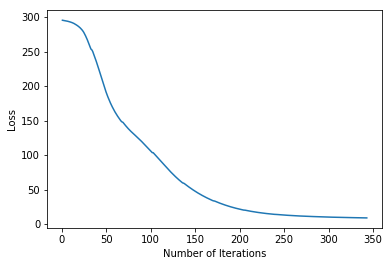

In [9]:
plotLoss(funVals)

In [534]:
# model_auto_mpg = nn.Sequential(nn.Linear(Xtrain_auto.shape[1], 32),
#                               nn.Tanh(),
#                               nn.Linear(32, 1),
#                               nn.ReLU())
# lossFunc_auto_mpg = nn.MSELoss()
# optimizer_auto_mpg = torch.optim.Adagrad(model_auto_mpg.parameters(), lr=1e-03)

In [535]:
# fval_auto_mpg = []
# for _ in range(100):
#     for i in range(Xtrain_auto.shape[0]//100):
#         optimizer_auto_mpg.zero_grad()
#         ypred_auto_mpg = model_auto_mpg(Xtrain_auto[i:i+100].float())
#         loss = lossFunc_auto_mpg(ypred_auto_mpg, ytrain_auto[i:i+100].float())
#         loss.backward()
#         optimizer_auto_mpg.step()
#         fval_auto_mpg.append(loss.item())

In [ ]:
# plotLoss(fval_auto_mpg[:])

In [10]:
def loadIrisDataset():
    iris_dataset = pd.read_csv("./dataset/iris/iris.data", header=-1)
    iris_dataset[4] = iris_dataset[4].astype('category').cat.codes
    iris_dataset = torch.tensor(iris_dataset.values, dtype=torch.double)
    return iris_dataset

In [11]:
iris_dataset = loadIrisDataset()
iris_dataset = iris_dataset[torch.randperm(iris_dataset.shape[0])]

In [12]:
train_iris = iris_dataset[:int(0.8 * iris_dataset.shape[0])]
test_iris = iris_dataset[int(0.8 * iris_dataset.shape[0]):]

Xtrain_iris = train_iris[:, :-1]
Xtrain_iris = (Xtrain_iris - Xtrain_iris.mean(dim=0))/Xtrain_iris.std(dim=0)
ytrain_iris = train_iris[:, -1].reshape(-1, 1)

Xtest_iris = test_iris[:, :-1]
Xtest_iris = (Xtest_iris - Xtest_iris.mean(dim=0))/Xtest_iris.std(dim=0)
ytest_iris = test_iris[:, -1].reshape(-1, 1)

In [13]:
iris_model = NeuralNetwork(Xtrain_iris.shape[1], 3, 64, ['relu', 'linear'], 'CELoss', 'Adam')

In [14]:
funVals, ypred = iris_model.train(Xtrain_iris, ytrain_iris, batch_size=100, iterations=500, alpha=1e-03)

1 8.314807454633494
2 8.206486675069984
3 8.099706163840137
4 7.994564122227178
5 7.891001202284693
6 7.7890551451033385
7 7.688648100142979
8 7.589723852627087
9 7.492252052934092
10 7.396094415533881
11 7.301193334611289
12 7.207440942870722
13 7.114792877051132
14 7.02315663523415
15 6.932467165685364
16 6.842632964735234
17 6.753617973494497
18 6.665403796528525
19 6.5779475842044866
20 6.491192027006312
21 6.405126487391411
22 6.319730169083349
23 6.234961019465201
24 6.150839277997982
25 6.067354470410786
26 5.9844639877662855
27 5.902200870774971
28 5.820658053073322
29 5.739781715616001
30 5.659540730827637
31 5.5799812854399935
32 5.501012689803721
33 5.422795731064263
34 5.345325801314389
35 5.2686532031633515
36 5.192754204738509
37 5.117645290748017
38 5.043366417659939
39 4.969961147323084
40 4.897512372187171
41 4.826003887964048
42 4.755445312766147
43 4.685858736840694
44 4.6172591099595826
45 4.549703412796116
46 4.483216288667526
47 4.417797854457857
48 4.353454612418

414 0.24457475291630051
415 0.24425447963350244
416 0.24393559081029909
417 0.24361821287648452
418 0.24330244548234328
419 0.24298760353572518
420 0.2426731602492914
421 0.24235952082585216
422 0.2420477560017747
423 0.2417376508337221
424 0.24142907483832163
425 0.24112166179662978
426 0.2408157871962168
427 0.24051049203084424
428 0.2402057270406396
429 0.23990169433535788
430 0.2395993822158028
431 0.23929799342486127
432 0.23900275639941101
433 0.23870977277779643
434 0.23841685292626472
435 0.23812577775564056
436 0.23783535563764605
437 0.23754571878084807
438 0.23725624860505595
439 0.23696706465829204
440 0.23667885961628773
441 0.23639243413868463
442 0.23610718361968586
443 0.23582321741190446
444 0.23554080510775746
445 0.23526006193264362
446 0.23498020317018992
447 0.2347011516861958
448 0.2344236314004534
449 0.23414783586780227
450 0.23387285244135056
451 0.23359934805352592
452 0.23332732130640257
453 0.23305628503254033
454 0.2327874095561523
455 0.2325192970486644
45

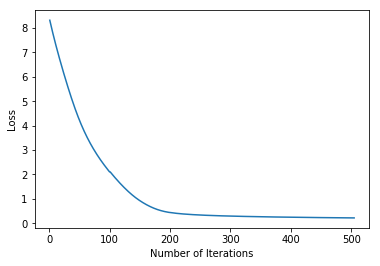

In [15]:
plotLoss(funVals)

In [ ]:
# model = nn.Sequential(nn.Linear(Xtrain_iris.shape[1], 32), 
#                       nn.ReLU(),
#                       nn.Linear(32, 3))

In [ ]:
# lossFn = nn.CrossEntropyLoss()

In [ ]:
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-03)

In [ ]:
# fval = []
# for epoch in range(1000):
#     for i in range(Xtrain_iris.shape[0]//100):
#         optimizer.zero_grad()
#         yp = model(Xtrain_iris[i:i+100].float())
#         loss = lossFn(yp, ytrain_iris[i:i+100].long()[:, 0])
#         loss.backward()
#         optimizer.step()
#         fval.append(loss.item())

In [ ]:
# plotLoss(fval)

In [18]:
def loadBreastCancerDataset():
    cancer_dataset = pd.read_csv("./dataset/breast-cancer/data.csv")
    cancer_dataset.drop(['Unnamed: 32', 'id'], axis=1, inplace=True)
    cancer_dataset['diagnosis'] = cancer_dataset['diagnosis'].astype('category').cat.codes
    cancer_dataset = torch.tensor(cancer_dataset.values, dtype=torch.double)
    return cancer_dataset

In [19]:
cancer_dataset = loadBreastCancerDataset()
cancer_dataset = cancer_dataset[torch.randperm(cancer_dataset.shape[0])]

In [20]:
train_cancer = cancer_dataset[:int(0.8*cancer_dataset.shape[0])]
test_cancer = cancer_dataset[int(0.8*cancer_dataset.shape[0]):]

Xtrain_cancer = train_cancer[:, 1:]
Xtrain_cancer = (Xtrain_cancer-Xtrain_cancer.mean(dim=0))/Xtrain_cancer.std(dim=0)
ytrain_cancer = train_cancer[:, 0].reshape(-1, 1)

Xtest_cancer = test_cancer[:, 1:]
Xtest_cancer = (Xtest_cancer-Xtest_cancer.mean(dim=0))/Xtest_cancer.std(dim=0)
ytest_cancer = test_cancer[:, 0].reshape(-1, 1)


In [24]:
cancer_model = NeuralNetwork(Xtrain_cancer.shape[1], 1, 32, ['relu', 'sigmoid'], 'BCELoss', 'Adam')

In [25]:
funVals, ypred = cancer_model.train(Xtrain_cancer, ytrain_cancer, batch_size=100, iterations=1000, alpha=1e-03)

4 2.9800841926096813
8 2.965088710393259
12 2.9281694692046014
16 2.8697967177367456
20 2.7902036589943986
24 2.6871951457033334
28 2.581764934297225
32 2.4997492609173597
36 2.4463006508719993
40 2.4123087360719313
44 2.3873268362096796
48 2.362939056317207
52 2.337786958687761
56 2.311065723258948
60 2.280169064041633
64 2.2454073851527405
68 2.2051566613899016
72 2.155022603590662
76 2.0939411762491487
80 2.0247842396779783
84 1.9564801437689592
88 1.9133104359914266
92 1.9099931035205793
96 1.9273791557952116
100 1.9364764129983372
100 1.9364764129983372
104 1.9132148832464158
108 1.8645158443602126
112 1.8184098016687058
116 1.7947335138587392
120 1.7891465235768174
124 1.7818907325855537
128 1.7642243525423191
132 1.7442048056630193
136 1.7273057071159446
140 1.7103713610920248
144 1.6911316729854544
148 1.6703910080705295
152 1.6526803707965272
156 1.6370913572111974
160 1.618003627253509
164 1.5970979686304767
168 1.5772557275769177
172 1.5599980464777723
176 1.5426365740110224

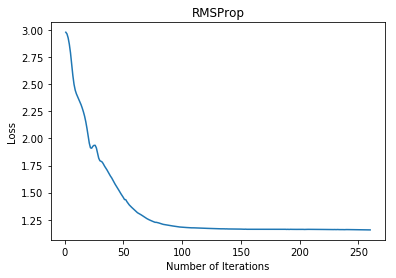

In [26]:
plotLoss(funVals, filePath="breast-cancer/results/RMSProp", title="RMSProp")